<h1>
Classification of Social Behavior 🐁🐀 - Elías Aburto Camacllanqui
</h1>
This code is adapted from a notebook created by Dipam Chakraborty at AIcrowd for the <a href=https://www.aicrowd.com/challenges/multi-agent-behavior-representation-modeling-measurement-and-applications>Multi-Agent Behavior Challenge</a>.

In [ ]:
# import some libraries
import os
import requests
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [ ]:
# Function to download some archives
def download_file(url, fname):
    if not os.path.isfile(fname):
        r = requests.get(url)
        if r.status_code == 200:
            with open(fname, 'wb') as f:
                f.write(r.content)
        else:
            print(f"Failed to download file: {fname}. Status code: {r.status_code}")

def download_and_unzip(url, fname):
    download_file(url, fname)
    if fname.endswith('.zip'):
        try:
            with zipfile.ZipFile(fname, 'r') as zip_ref:
                zip_ref.extractall('.')
        except zipfile.BadZipFile:
            print(f"Error: The file {fname} is not a zip file.")

In [ ]:
# Download archives
download_and_unzip("https://data.caltech.edu/records/s0vdx-0k302/files/task1_classic_classification.zip?download=1", "task1_classic_classification.zip")
download_file("https://data.caltech.edu/records/s0vdx-0k302/files/calms21_convert_to_npy.py?download=1", "calms21_convert_to_npy.py")

# Excecute the script to converte data
!python calms21_convert_to_npy.py --input_directory '.' --output_directory '.'

Saving ./calms21_task1_train
Saving ./calms21_task1_test


In [ ]:
# Load data
def load_data(file_path):
    data_dict = np.load(file_path, allow_pickle=True).item()
    dataset = next(iter(data_dict.values()))
    sequence_id = next(iter(dataset.keys()))
    vocabulary = dataset[sequence_id]['metadata']['vocab']
    return dataset, vocabulary

training_data, vocab = load_data('calms21_task1_train.npy')
test_data, _ = load_data('calms21_task1_test.npy')

In [ ]:
# Function to Preprocessing

from tensorflow.keras.preprocessing.sequence import pad_sequences

def prepare_data(data):
    X = [data[seq]['keypoints'].reshape(len(data[seq]['annotations']), -1) for seq in data]
    y = [data[seq]['annotations'] for seq in data]

    # Padding to ensure all sequences have the same length
    X_padded = pad_sequences(X, padding='post', dtype='float32')
    y_padded = pad_sequences(y, padding='post', value=3)

    return X_padded, y_padded

In [ ]:
# Preprocessing data

X_train, y_train = prepare_data(training_data)
X_test, y_test = prepare_data(test_data)

In [ ]:
# Customize a function to ignore class 3 (padding)
import tensorflow as tf

def custom_loss(y_true, y_pred):
    # Create a mask to ignore class 3
    mask = tf.cast(tf.not_equal(y_true, 3), dtype=tf.float32)

    # Calculate sparse categorical cross-entropy loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # Apply the mask to ignore loss where the class is 3
    loss = loss * mask

    # Normalize by the number of valid samples (to avoid bias from ignored 3s)
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [ ]:
# Define and compile the model using the input layer.
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(64, return_sequences=True)(input_layer)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(len(vocab), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# loss='sparse_categorical_crossentropy'

In [ ]:
# Entrenar el modelo
history = model.fit(X_train, y_train, validation_split=0.2, epochs=500, batch_size=32)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.0698 - loss: 1.4239 - val_accuracy: 0.1563 - val_loss: 1.0794
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.0817 - loss: 1.1814 - val_accuracy: 0.1547 - val_loss: 0.8067
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0881 - loss: 1.0158 - val_accuracy: 0.1547 - val_loss: 0.6203
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0860 - loss: 0.8778 - val_accuracy: 0.1547 - val_loss: 0.5198
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.0803 - loss: 0.8749 - val_accuracy: 0.1547 - val_loss: 0.4792
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.0857 - loss: 0.8622 - val_accuracy: 0.1547 - val_loss: 0.4740
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.0789 - loss: 0.8571 - val_accuracy: 0.1547 - val_loss: 0.4849
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0836 - loss: 0.8217 - val_accuracy: 0.1547 - val_loss: 0.5131
Epoch 9/

In [ ]:
# Evaluación del modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step - accuracy: 0.1770 - loss: 0.6590
Test Accuracy: 17.70%


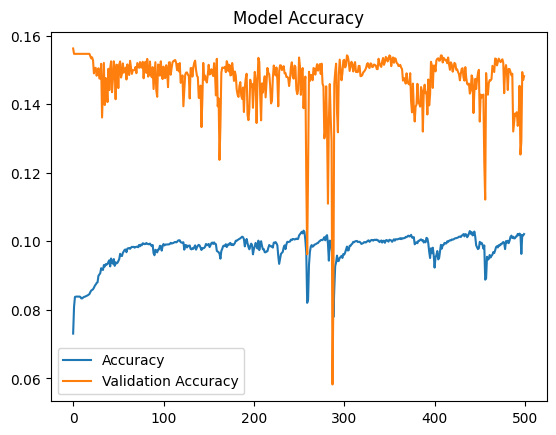

In [ ]:
# Visualización del rendimiento
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

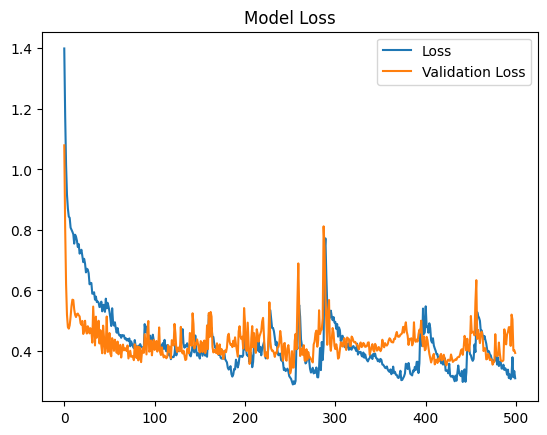

In [ ]:

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()